This notebook contains implementation of VAE and Normalizing Flow generative models using FashionMNIST dataset.

Literature:
https://arxiv.org/abs/1605.08803 Density estimation using Real NVP
Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio

https://arxiv.org/abs/1908.09257 Normalizing Flows: An Introduction and Review of Current Methods
Ivan Kobyzev, Simon J.D. Prince, Marcus A. Brubaker

https://arxiv.org/abs/1906.02691 An Introduction to Variational Autoencoders
Diederik P. Kingma, Max Welling

Imports: We are using PyTorch

In [3]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

Loading the FashionMNIST dataset locally and saving it.

In [4]:
transform = transforms.ToTensor()

train_dataset = FashionMNIST(
    root='../data', train=True, download=True, transform=transform
)
test_dataset = FashionMNIST(
    root='../data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

import matplotlib.pyplot as plt
import torchvision

# Get one batch
images, labels = next(iter(train_loader))

# Make a grid of 8x8 images (64 images in one batch)
img_grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2)

Importing the two models that we are interested in. vae.py and nrm_flow.py have been created and saved in the folder models.

In [5]:
from models.vae import VAE, vae_loss
from models.nrm_flow import AffineCoupling, NormalizingFlowModel


by setting torch.device to cuda, we use the GPU for training our models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
input_dim  = 28 * 28    # 784
hidden_dim = 512        # feel free to tweak
latent_dim = 20         # ditto

In [9]:
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [11]:
for epoch in range(10):
    vae.train()
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)

        recon, mu, logvar = vae(batch)
        MSE, KLD = vae_loss(recon, batch, mu, logvar)
        loss = MSE + KLD
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 784x512)

In [7]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)  # 64 samples from N(0, I)
    samples_vae = vae.decode(z).cpu()       # Decode to image space
    samples_vae = samples_vae.view(-1, 1, 28, 28)


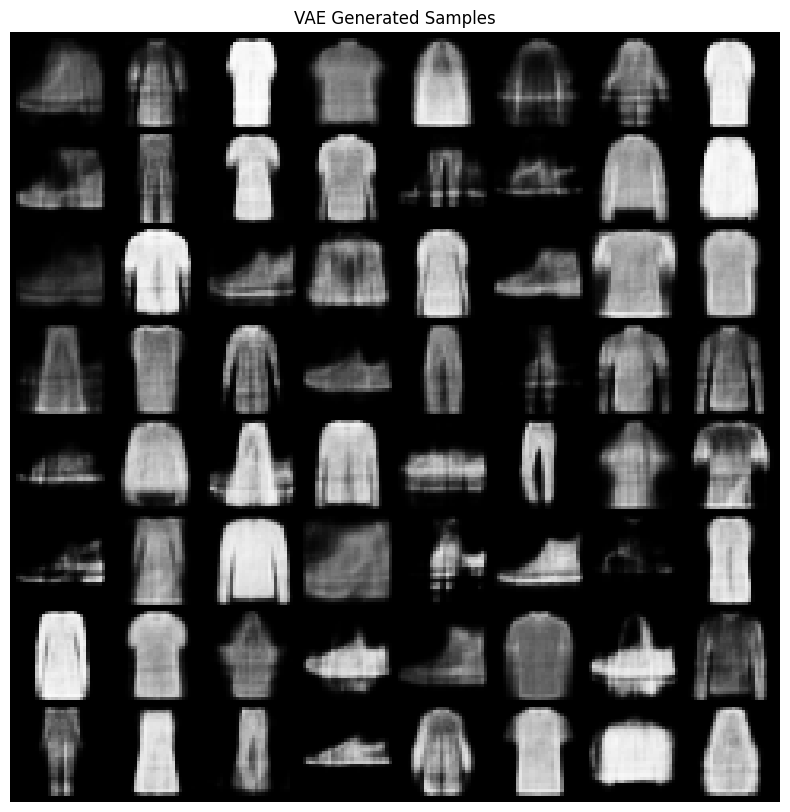

In [8]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(samples_vae, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('VAE Generated Samples')
plt.savefig("vae_generated_samples.png")
plt.show()


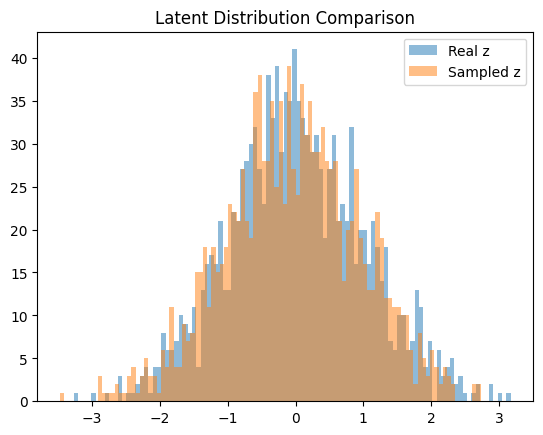

In [10]:
with torch.no_grad():
    x_batch, _ = next(iter(test_loader))
    x_batch = x_batch.to(device).view(-1, 784)
    recon, mu, logvar = vae(x_batch)
    z_real = vae.reparameterize(mu, logvar)
    z_fake = torch.randn_like(z_real)

    real_vals = z_real.detach().cpu().view(-1).numpy()
    fake_vals = z_fake.cpu().view(-1).numpy()

    plt.hist(real_vals, bins=100, alpha=0.5, label='Real z')
    plt.hist(fake_vals, bins=100, alpha=0.5, label='Sampled z')
    plt.legend()
    plt.title('Latent Distribution Comparison')
    plt.show()


Now training Normalizing Flow.

In [16]:
flows = [AffineCoupling(784, 512, swap=(i % 2 == 1)) for i in range(8)]
nf_model = NormalizingFlowModel(flows, input_dim=784).to(device)
optimizer = torch.optim.Adam(nf_model.parameters(), lr=1e-3)

In [17]:
for epoch in range(20):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device).view(-1, 784)
        MSE, KLD = -nf_model.log_prob(batch).mean()
        loss = MSE +KLD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: -1024.1777
Epoch 2, Loss: -1279.7500
Epoch 3, Loss: -1349.8280
Epoch 4, Loss: -1394.5814
Epoch 5, Loss: -1424.6339
Epoch 6, Loss: -1447.8777
Epoch 7, Loss: -1465.3575
Epoch 8, Loss: -1479.0362
Epoch 9, Loss: -1493.6275
Epoch 10, Loss: -1505.0678
Epoch 11, Loss: -1515.7270
Epoch 12, Loss: -1514.6222
Epoch 13, Loss: -1527.1922
Epoch 14, Loss: -1535.1279
Epoch 15, Loss: -1544.3807
Epoch 16, Loss: -1552.6781
Epoch 17, Loss: -1557.7237
Epoch 18, Loss: -1552.4058
Epoch 19, Loss: -1564.1173
Epoch 20, Loss: -1569.3651


In [18]:
with torch.no_grad():
    # Sample from base distribution (same dim as input: 784 for 28x28 images)
    z = torch.randn(64, 784).to(device)

    # Invert the flow: z → x
    samples_nf = nf_model.inverse(z).cpu()
    samples_nf = samples_nf.view(-1, 1, 28, 28)
    samples_nf = torch.clamp(samples_nf, 0.0, 1.0)  # optional, for clean visualization


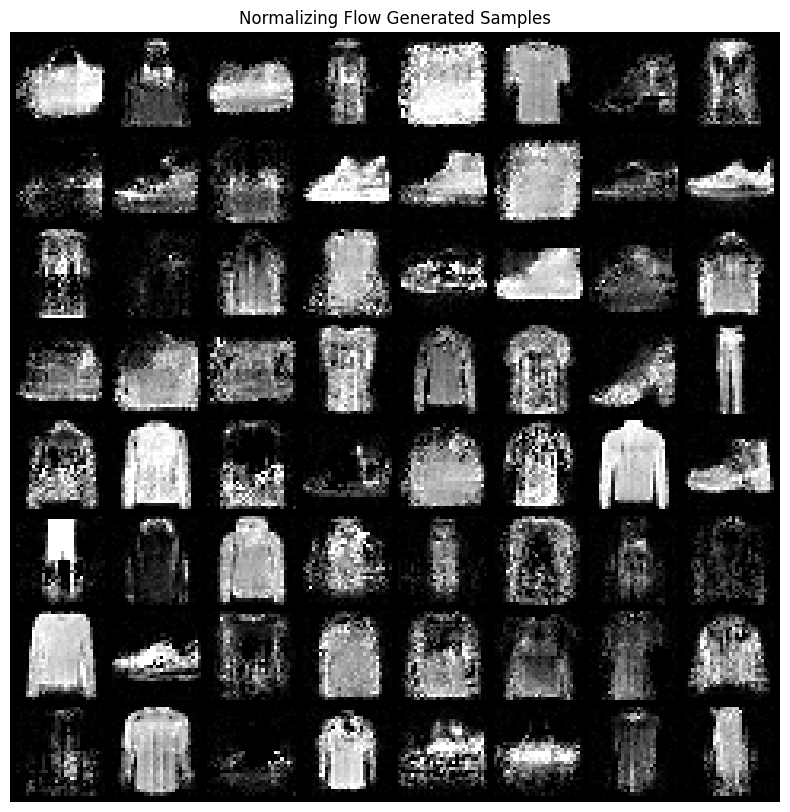

In [19]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(samples_nf, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Normalizing Flow Generated Samples')
plt.savefig("nf__generated_samples.png")
plt.show()


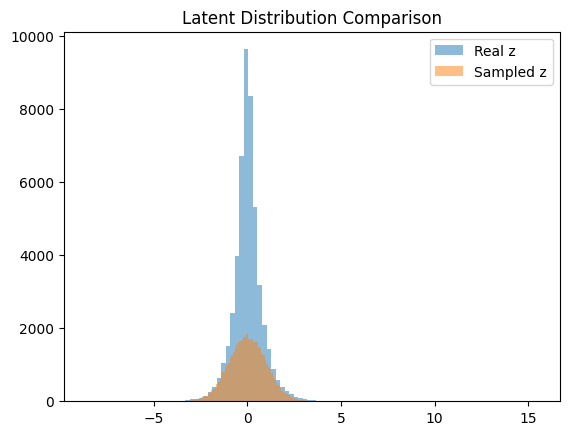

In [20]:
with torch.no_grad():
    x_batch, _ = next(iter(test_loader))
    x_batch = x_batch.to(device).view(-1, 784)
    z_real, _ = nf_model(x_batch)
    z_fake = torch.randn_like(z_real)

    plt.hist(z_real.cpu().view(-1).numpy(), bins=100, alpha=0.5, label='Real z')
    plt.hist(z_fake.cpu().view(-1).numpy(), bins=100, alpha=0.5, label='Sampled z')
    plt.legend()
    plt.title('Latent Distribution Comparison')
    plt.show()


In [55]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from models.nrm_flow import AffineCoupling, NormalizingFlowModel

# ── 1) Hyperparams ─────────────────────────────────────────────────────────────
batch_size     = 128
epochs         = 50
warmup_epochs  = 20      # β ramps 0→1 over these epochs
latent_dim     = 20
hidden_dim     = 512
flow_steps     = 4
learning_rate  = 1e-3
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 2) Data ───────────────────────────────────────────────────────────────────
transform = transforms.ToTensor()
train_ds  = FashionMNIST(root="../data", train=True,  download=True, transform=transform)
train_ld  = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)

# ── 3) VAE Definition ─────────────────────────────────────────────────────────
class VAE(nn.Module):
    def __init__(self, in_dim=784, h=hidden_dim, z=latent_dim):
        super().__init__()
        # encoder
        self.fc1       = nn.Linear(in_dim, h)
        self.fc_mu     = nn.Linear(h, z)
        self.fc_logvar = nn.Linear(h, z)
        # decoder
        self.fc3 = nn.Linear(z, h)
        self.fc4 = nn.Linear(h, in_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std * torch.randn_like(std)

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))    # Bernoulli decoder

    def forward(self, x):
        mu, logvar = self.encode(x)
        z0         = self.reparameterize(mu, logvar)
        return mu, logvar, z0

# ── 4) Flow posterior ──────────────────────────────────────────────────────────
flows = [
    AffineCoupling(latent_dim, hidden_dim, swap=(i % 2 == 1))
    for i in range(flow_steps)
]
flow_post = NormalizingFlowModel(flows, input_dim=latent_dim).to(device)

# ── 5) Instantiate models & optim ────────────────────────────────────────────
vae_flow = VAE().to(device)
opt = torch.optim.Adam(
    list(vae_flow.parameters()) + list(flow_post.parameters()),
    lr=learning_rate
)

# ── 6) Training loop ─────────────────────────────────────────────────────────
for epoch in range(1, epochs+1):
    beta    = min(1.0, epoch / warmup_epochs)
    sum_recon, sum_kl = 0.0, 0.0
    N = len(train_ld.dataset)

    vae_flow.train()
    flow_post.train()
    for imgs, _ in train_ld:
        x = imgs.view(-1, 784).to(device)

        # 1) encode to base Gaussian
        mu, logvar, z0 = vae_flow(x)

        # 2) flow transform
        zK, log_det = flow_post(z0)

        # 3) decode
        x_rec = vae_flow.decode(zK)

        # 4) reconstruction loss (Bernoulli)
        recon = F.binary_cross_entropy(x_rec, x, reduction="sum")

        # 5) KL with flow:
        # log q0(z0|x)
        log_q0  = (-0.5 * ((z0 - mu)**2 / logvar.exp() + logvar + math.log(2*math.pi))).sum(dim=1)
        # log p(zK)
        log_pzk = (-0.5 * (zK**2 + math.log(2*math.pi))).sum(dim=1)
        # full KL
        kl = (log_q0 - log_pzk - log_det).sum()

        # 6) total loss
        loss = recon + beta * kl

        opt.zero_grad()
        loss.backward()
        opt.step()

        sum_recon += recon.item()
        sum_kl    += kl.item()

    print(f"Epoch {epoch:02d} β={beta:.2f} | Recon={sum_recon/N:6.3f} | KL={sum_kl/N:6.3f}")


Epoch 01 β=0.05 | Recon=251.377 | KL=77.257
Epoch 02 β=0.10 | Recon=224.022 | KL=50.861
Epoch 03 β=0.15 | Recon=220.459 | KL=41.111
Epoch 04 β=0.20 | Recon=219.146 | KL=36.443
Epoch 05 β=0.25 | Recon=218.555 | KL=33.533
Epoch 06 β=0.30 | Recon=218.400 | KL=31.336
Epoch 07 β=0.35 | Recon=218.383 | KL=29.489
Epoch 08 β=0.40 | Recon=218.588 | KL=27.869
Epoch 09 β=0.45 | Recon=218.754 | KL=26.505
Epoch 10 β=0.50 | Recon=219.063 | KL=25.226
Epoch 11 β=0.55 | Recon=219.325 | KL=24.087
Epoch 12 β=0.60 | Recon=219.693 | KL=23.054
Epoch 13 β=0.65 | Recon=220.093 | KL=22.121
Epoch 14 β=0.70 | Recon=220.395 | KL=21.283
Epoch 15 β=0.75 | Recon=220.791 | KL=20.484
Epoch 16 β=0.80 | Recon=221.175 | KL=19.740
Epoch 17 β=0.85 | Recon=221.553 | KL=19.048
Epoch 18 β=0.90 | Recon=221.954 | KL=18.436
Epoch 19 β=0.95 | Recon=222.314 | KL=17.851
Epoch 20 β=1.00 | Recon=222.717 | KL=17.293
Epoch 21 β=1.00 | Recon=222.620 | KL=17.166
Epoch 22 β=1.00 | Recon=222.538 | KL=17.062
Epoch 23 β=1.00 | Recon=222.486 

In [57]:
with torch.no_grad():
    z = torch.randn(64, 20).to(device)  # 64 samples from N(0, I)
    samples_vae = vae_flow.decode(z).cpu()       # Decode to image space
    samples_vae = samples_vae.view(-1, 1, 28, 28)


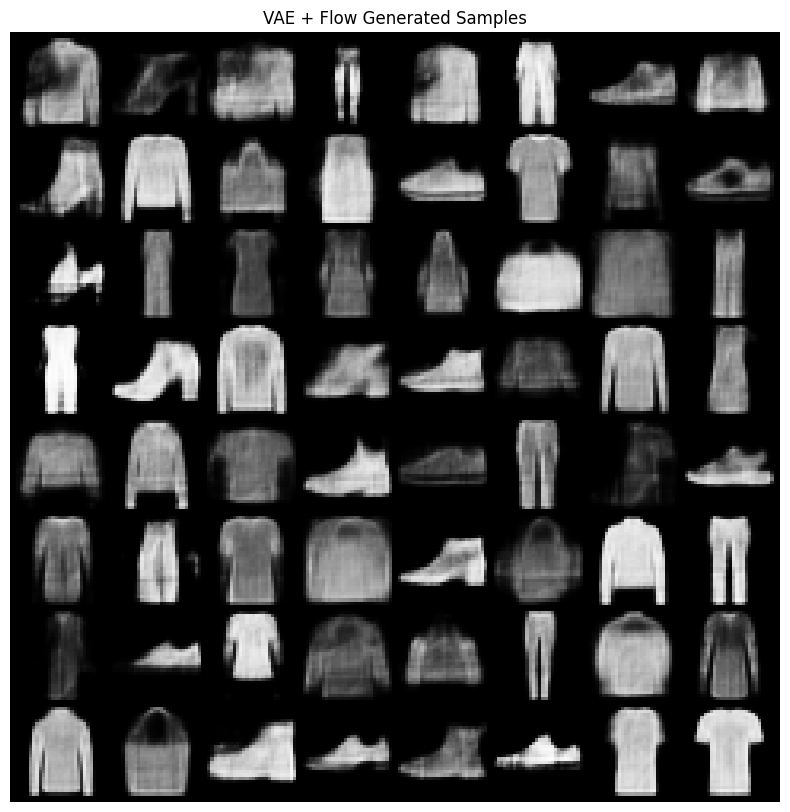

In [61]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(samples_vae, nrow=8, padding=2)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('VAE + Flow Generated Samples')
plt.savefig("vae_and_flow_generated_samples.png")
plt.show()


In [68]:
# ──────────────────────────────────────────────────────────────────────────────
# 0) Install dependencies if you haven’t already:
# pip install torchmetrics torchvision scikit-learn
# ──────────────────────────────────────────────────────────────────────────────

import torch, math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import inception_v3
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from sklearn.neighbors import NearestNeighbors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────────────────────────────────────────────────────────────
# 1) Preprocessing pipeline for Inception v3 (299×299, 3-channel)
# ──────────────────────────────────────────────────────────────────────────────
prep = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.Lambda(lambda x: x.repeat(3,1,1) if x.shape[0]==1 else x),  # gray→RGB
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

def make_loader(imgs, batch_size=64):
    """
    imgs: torch.Tensor [N, C, H, W], values in [0,1]
    returns a DataLoader that yields preprocessed batches
    """
    ds = TensorDataset(imgs)
    return DataLoader(ds, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: torch.stack([prep(x[0]) for x in b]))

# ──────────────────────────────────────────────────────────────────────────────
# 2) Compute FID and IS
# ──────────────────────────────────────────────────────────────────────────────
def compute_fid_is(real_imgs, gen_imgs, bs=64):
    real_ld = make_loader(real_imgs, bs)
    gen_ld  = make_loader(gen_imgs,  bs)

    fid_m = FrechetInceptionDistance(feature="pool3", normalize=True).to(device)
    is_m  = InceptionScore().to(device)

    # accumulate
    for batch in real_ld:
        fid_m.update(batch.to(device), real=True)
    for batch in gen_ld:
        fid_m.update(batch.to(device), real=False)
        is_m.update(batch.to(device))

    fid_val = fid_m.compute().item()
    is_mean, is_std = is_m.compute()
    return fid_val, is_mean.item(), is_std.item()

# ──────────────────────────────────────────────────────────────────────────────
# 3) Compute Precision / Recall via k-NN on Inception features
# ──────────────────────────────────────────────────────────────────────────────
def compute_precision_recall(real_imgs, gen_imgs, bs=64, k=5):
    # load a frozen Inception up to pool3
    net = inception_v3(pretrained=True, transform_input=False).to(device).eval()
    net.fc = torch.nn.Identity()

    def extract_feats(imgs):
        loader = make_loader(imgs, bs)
        feats = []
        with torch.no_grad():
            for batch in loader:
                f = net(batch.to(device))
                feats.append(f.cpu().numpy())
        return np.vstack(feats)

    real_feats = extract_feats(real_imgs)
    gen_feats  = extract_feats(gen_imgs)

    # k-NN distances within each set
    nbrs_r = NearestNeighbors(n_neighbors=k+1).fit(real_feats)
    d_r, _ = nbrs_r.kneighbors(real_feats)
    thr_r  = np.median(d_r[:, -1])    # radius for real manifold

    nbrs_g = NearestNeighbors(n_neighbors=k+1).fit(gen_feats)
    d_g, _ = nbrs_g.kneighbors(gen_feats)
    thr_g  = np.median(d_g[:, -1])    # radius for gen manifold

    # precision: gen points that fall within real manifold radius
    dist_g2r, _ = nbrs_r.kneighbors(gen_feats[:, :], n_neighbors=1)
    precision = np.mean(dist_g2r[:,0] < thr_r)

    # recall: real points that fall within gen manifold radius
    dist_r2g, _ = nbrs_g.kneighbors(real_feats[:, :], n_neighbors=1)
    recall    = np.mean(dist_r2g[:,0] < thr_g)

    return precision, recall

# ──────────────────────────────────────────────────────────────────────────────
# 4) Example usage (limit to N=1000 to save memory)
# ──────────────────────────────────────────────────────────────────────────────
N = 1000
real_imgs_sub = real_imgs[:N]  # your test set samples (tensor [N,1,28,28])
gen_imgs_sub  = gen_imgs[:N]   # your generated samples (tensor [N,1,28,28])

fid, is_m, is_s = compute_fid_is(real_imgs_sub, gen_imgs_sub)
prec, rec      = compute_precision_recall(real_imgs_sub, gen_imgs_sub)

print(f"FID: {fid:.3f}")
print(f"Inception Score: {is_m:.3f} ± {is_s:.3f}")
print(f"Precision: {prec:.3f}, Recall: {rec:.3f}")


NameError: name 'real_imgs' is not defined